In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

from src.Resampler import Resampler

In [2]:
P = 5
Q = 7
resampl = P/Q
N = 4096
resamplQ = np.round(resampl * N) / N
print(resampl)
print(resamplQ)

0.7142857142857143
0.71435546875


700
500


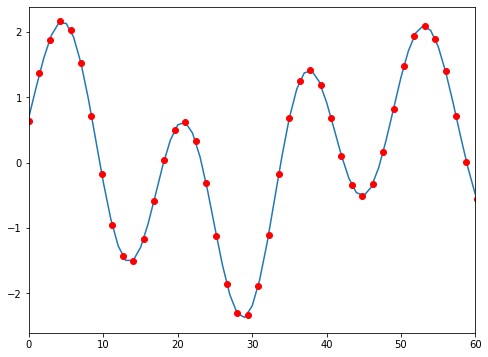

In [3]:
sig = ( np.cos(2*np.pi*1/50*np.arange(Q*100)) + 1.2*np.sin(2*np.pi*3/50*np.arange(Q*100)) - 
       .3*np.cos(2*np.pi*3.5/50*np.arange(Q*100)) )
sigResRef = signal.resample_poly(sig, P, Q)
print(len(sig))
print(len(sigResRef))
plt.subplots(figsize=(8, 6))
plt.plot(sig);
xRes = np.arange(P*100)* Q/P
plt.plot(xRes, sigResRef, 'ro');
plt.xlim(0, 60);

In [4]:
taps = 16
nFilt = N * taps
hBWsig = .35
filt = signal.firwin2(nFilt, [0., .35/N, .5/N, 1.], [1., 1., 0., 0.])
filt = N*filt / np.sum(filt)
# w, h = signal.freqz(filt, 2**10)
# plt.plot(w/np.pi, 20*np.log10(np.abs(h)/np.max(np.abs(h))));
# plt.xlim(0, 0.02);

res = Resampler(resampl, filt, N, dtype=float, impl=('float', None))

In [5]:
res.loadIntoBuffer(sig)
val = 0
sigRes = np.array([])
while val is not None:
    val = res.step()
    if val is not None:
        sigRes = np.append(sigRes, val)
print(len(sigRes))

501


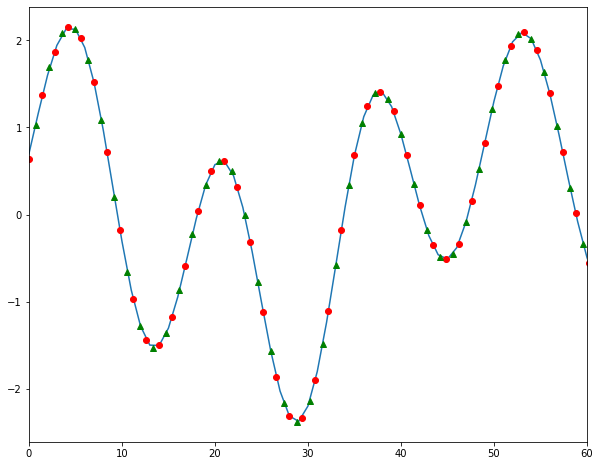

In [6]:
plt.subplots(figsize=(10, 8))
plt.plot(sig);
plt.plot(xRes, sigResRef, 'ro');
delayTrial = 1.9 # ???
delay_ = resampl*(taps//2) + delayTrial
plt.plot(xRes - delay_, sigRes[1:], 'g^');
plt.xlim(0, 60);

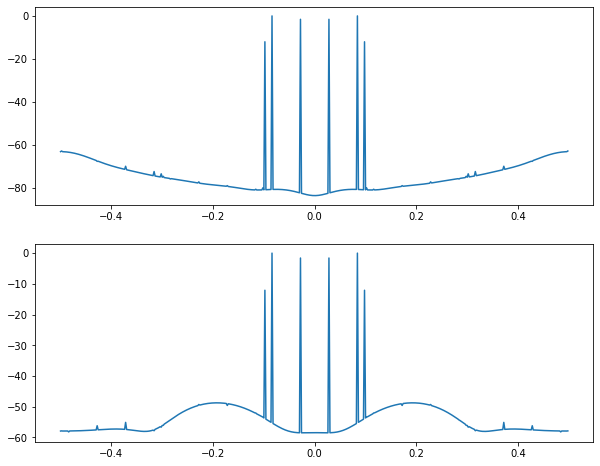

In [7]:
freqs = np.fft.fftshift( np.fft.fftfreq(len(sigResRef)) )
specRef = np.fft.fftshift( np.abs(np.fft.fft(sigResRef))**2 )
specRef = 10*np.log10(specRef / np.max(specRef))
spec = np.fft.fftshift( np.abs(np.fft.fft(sigRes[1:]))**2 )
spec = 10*np.log10(spec / np.max(spec))

plt.subplots(2, 1, figsize=(10, 8))
plt.subplot(211)
plt.plot(freqs, specRef);
plt.subplot(212)
plt.plot(freqs, spec);

### Test integer implementation

In [8]:
f = 1/50
sig = ( np.exp(1j*2*np.pi*f*np.arange(Q*100)) + 1.2*np.exp(1j*2*np.pi*3*f*np.arange(Q*100)) - 
       .3*np.exp(1j*2*np.pi*3.5*f*np.arange(Q*100)) )

sigSc = 12
sigNorm = .99 * sig / max(sig) * (2**(sigSc-1)-1) / (2**(sigSc-1))
sigInt = np.round(sigNorm * 2**(sigSc-1))

impl = ('int', (16, 30))
res = Resampler(resampl, filt, N, dtype=complex, impl=impl)
res.loadIntoBuffer(sigInt)
val = 0
sigResInt = np.array([])
while val is not None:
    val = res.step()
    if val is not None:
        sigResInt = np.append(sigResInt, val)
print(len(sigResInt))

501


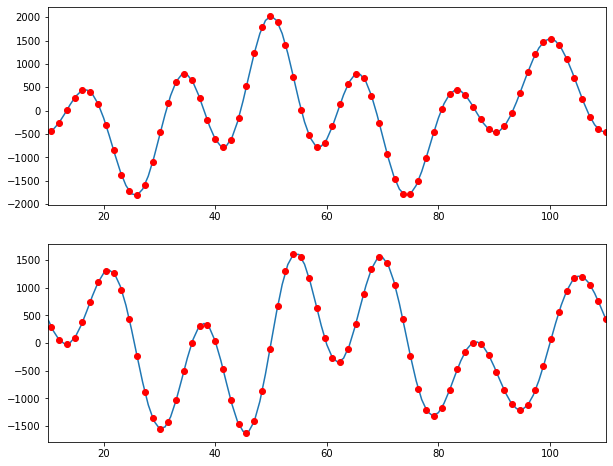

In [9]:
plt.subplots(2, 1, figsize=(10, 8))
plt.subplot(211)
plt.plot(sigInt.real);
plt.plot(xRes - delay_, sigResInt[1:].real, 'ro');
plt.xlim(10, 110);
plt.subplot(212)
plt.plot(sigInt.imag);
plt.plot(xRes - delay_, sigResInt[1:].imag, 'ro');
plt.xlim(10, 110);

## Test convert() function

In [10]:
res2Ratio = 5/9
res2 = Resampler(res2Ratio, filt, N, dtype=complex, impl=impl)

dW = 12
convert = False
if convert:
    res2.convert(dW)

    with open('./vhdl/Resampler.vhd') as f:
        print(f.read())

### Test RTL-model

In [11]:
testSig = sigInt

tb = res2.test_rtl(testSig, sigSc, wrToFile=False)
tb.config_sim(trace=False)
tb.run_sim()

390
389


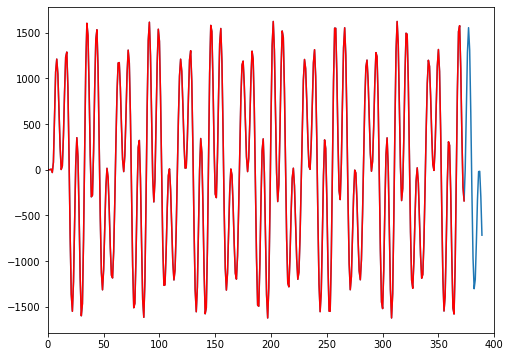

In [12]:
print(len(res2.rtlRefs))
print(len(res2.rtlOuts))
plt.subplots(figsize=(8, 6))
plt.plot(res2.rtlRefs[:].imag);
plt.plot(res2.rtlOuts[taps-1:].imag, 'r');
plt.xlim(0, 400);